In [1]:
%run imports.ipynb

In [2]:
from dask_kubernetes import KubeCluster
cluster = KubeCluster(n_workers=30)
cluster

In [3]:
from dask.distributed import Client
client = Client(cluster)
client

Client Scheduler: tcp://10.33.122.183:40945 Dashboard: /user/carlo%20mariade%20marco1/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [4]:
chromosomes = ['3L', '3R', '2L', '2R', 'X']

In [5]:
out_species = ['arab', 'chri', 'epir', 'mela', 'meru', 'quad']

In [6]:
an_col = 'BFcol', 'GNcol', 'CIcol', 'GHcol'
an_gam = 'GHgam', 'BFgam', 'GNgam'
an_na = 'GM', 'GW'

In [7]:
calldata_out= zarr.open('../data/outgroup_alleles_phase2.zarr')

In [8]:
calldata_biallel= zarr.open('../data/phase2_biallel_allele_count.zarr')

In [9]:
metadata = pd.read_csv("samples.meta.txt", sep="\t")
metadata.head()

,ox_code,src_code,population,country,location,site,contributor,contact,year,m_s,sex,n_sequences,mean_coverage,ebi_sample_acc,latitude,longitude
0,AA0040-C,Twifo_Praso__E2,GHcol,Ghana,Twifo Praso,Twifo Praso,David Weetman,David Weetman,2012,M,F,95033368,30.99,ERS311878,5.60858,-1.54926
1,AA0041-C,Twifo_Praso__H3,GHcol,Ghana,Twifo Praso,Twifo Praso,David Weetman,David Weetman,2012,M,F,95843804,31.70,ERS311886,5.60858,-1.54926
2,AA0042-C,Takoradi_C7,GHcol,Ghana,Takoradi,Takoradi,David Weetman,David Weetman,2012,M,F,107420666,35.65,ERS311894,4.91217,-1.77397
3,AA0043-C,Takoradi_H8,GHcol,Ghana,Takoradi,Takoradi,David Weetman,David Weetman,2012,M,F,95993752,29.46,ERS311902,4.91217,-1.77397
4,AA0044-C,Takoradi_D10,GHcol,Ghana,Takoradi,Takoradi,David Weetman,David Weetman,2012,M,F,103044262,33.67,ERS311910,4.91217,-1.77397


In [10]:
ac_cache = dict()

def load_ac(chrom, pop):
    if (chrom, pop) in ac_cache:
        return ac_cache[chrom, pop]
    else:
        if pop in out_species:
            ac = calldata_out[chrom][pop]
        else:
            ac = calldata_biallel[chrom][pop]
            ac_cache[chrom, pop] = ac
        return ac

In [11]:
fourpop_cache = dict()

-----------------------------------------
## f3 Statistics

In [26]:
def f4_analysis(chroms, A, B, C, regions=None, blen=100000, plot=False, ax=None):
    
    
    
    region_str = ",".join(["{0}_{1}".format(r.start, r.stop) for r in regions])
    
    key = (",".join(chroms), region_str, A, B, C, blen)
    if key in fourpop_cache:
        # re-use from cache
        d, d_se, d_z, d_vb, d_vj = fourpop_cache[key]
        
    else:
        # load allele counts
        aca = dask.array.vstack([load_ac(chrom, A)[region] for chrom, region in zip(chroms, regions)])
        acb = dask.array.vstack([load_ac(chrom, B)[region] for chrom, region in zip(chroms, regions)])
        acc = dask.array.vstack([load_ac(chrom, C)[region] for chrom, region in zip(chroms, regions)])
            
        # run D test
        d, d_se, d_z, d_vb, d_vj = allel.average_patterson_f3(aca, acb, acc, 
                                                                     blen=blen)
        
        # cache for re-use
        fourpop_cache[key] = d, d_se, d_z, d_vb, d_vj
    
    return d, d_se, d_z, d_vb, d_vj

def f4_analys(As, Bs, Cs, chroms=chromosomes, regions=None, blen=100000):
    
    if regions is None:
        regions = [slice(None)] * 4
    
    region_str = ",".join(["{0}_{1}".format(r.start, r.stop) for r in regions])
    # normalise inputs
    if not isinstance(chroms, (list, tuple)):
        chroms = [chroms]
    if not isinstance(As, (list, tuple)):
        As = [As]
    if not isinstance(Bs, (list, tuple)):
        Bs = [Bs]
    if not isinstance(Cs, (list, tuple)):
        Cs = [Cs]

    # setup output table
    tbl = [['chromosome', 'test', 'f3', 'SE', 'Z']]

    for A in As:
        for B in Bs:
            if A != B:
                for C in Cs:
                        if B != C:
                            d, d_se, d_z, _, _ = f4_analysis(chroms, A, B, C,  
                                                             regions=regions, blen=blen)
                            test = 'f3(%s, %s; %s)' % (A, B, C)
                            row = [",".join(chroms), test, d, d_se, d_z]
                            tbl += [row]

    # display results
    (etl
     .wrap(tbl)
     .interpolate('f3', '%.3f')
     .interpolate('SE', '%.4f')
     .interpolate('Z', '%.1f')
     .displayall(index_header=False, 
                 tr_style=lambda row: 'background-color: %s' % ('#afa' if float(row.Z) > 5 else '#aaf' if float(row.Z) < -5 else 'white')))
    return tbl


def tbl_d_plot(table, title):
    # plot
    tbl = etl.wrap(table).sort('test')
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20, 10))
    
    ## First Plot - Bar Plot
    x = tbl.values('f3').array()
    y = np.arange(tbl.nrows())
    ax1.axvline(0, color='r', lw=1)
    xerr = tbl.values('SE').array()
    ax1.errorbar(x, y, xerr=xerr, fmt='o', lw=1, color='k', mew=1, mfc='k')
    ax1.set_yticks(y)
    ylbls = ['%s; Z = %.1f' % (v.test, v.Z) for v in tbl.records()]
    ax1.set_yticklabels(ylbls)
    ax1.yaxis.tick_right()
    ax1.xaxis.tick_top()
    ax1.xaxis.set_label_position('top')
    ax1.set_xlim(-.2,.2)
    ax1.set_ylim(-1, y.size)
    ax1.grid(axis='both', color='#dddddd')
    ax1.set_xlabel("F3 Statistics Barplot")
    fig.suptitle('%s' % (title), y=1.02, fontsize=16)

    ## Second plot - Heatmap
    results = etl.todataframe(tbl)
    df1 = results[['test', 'f3','Z']].round(2)
    heatmap1_data = pd.pivot_table(df1, values='Z', 
                     index=['test'], 
                     columns='f3')
    lm = sns.heatmap(heatmap1_data, cmap="RdBu", vmin=15, vmax=-15, annot=True)
    ax2 = lm.axes
    ax2.set_xlim(-.7)
    ax2.set_ylim(40.4)
    ax2.xaxis.set_label_position('top')
    ax2.xaxis.tick_top()
    plt.xticks(rotation=70)
    ax2.set_xlabel("F3 Statistics Heatmap")
    ax2.invert_yaxis()
    plt.text(1.02, 0.5, 'Z-score', {'fontsize': 15},
             horizontalalignment='left',
             verticalalignment='center',
             rotation=90,
             clip_on=False,
             transform=plt.gca().transAxes)

    ax2.grid(False, 'major')
    ax2.grid(True, 'minor')
    ax2.set_yticks([t - 0.5 for t in ax2.get_yticks()], minor=True)
    sns.despine()
    fig.tight_layout()
    plt.show()  

In [27]:
A = an_gam
B = an_na
C = an_col

In [28]:
f3_test_1 = f4_analys(A, B, C, chroms=("3L", "3R"),
                regions=(slice(18_000_000, 41_000_000), slice(1, 24000000)))

chromosome,test,f3,SE,Z
"3L,3R","f3(GHgam, GM; BFcol)",0.033,0.0030,11.1
"3L,3R","f3(GHgam, GM; GNcol)",0.040,0.0037,10.7
"3L,3R","f3(GHgam, GM; CIcol)",0.036,0.0032,11.3
"3L,3R","f3(GHgam, GM; GHcol)",0.036,0.0031,11.4
"3L,3R","f3(GHgam, GW; BFcol)",0.039,0.0038,10.4
"3L,3R","f3(GHgam, GW; GNcol)",0.048,0.0046,10.3
"3L,3R","f3(GHgam, GW; CIcol)",0.043,0.0040,10.7
"3L,3R","f3(GHgam, GW; GHcol)",0.043,0.0040,10.7
"3L,3R","f3(BFgam, GM; BFcol)",0.030,0.0032,9.2
"3L,3R","f3(BFgam, GM; GNcol)",0.037,0.0040,9.2


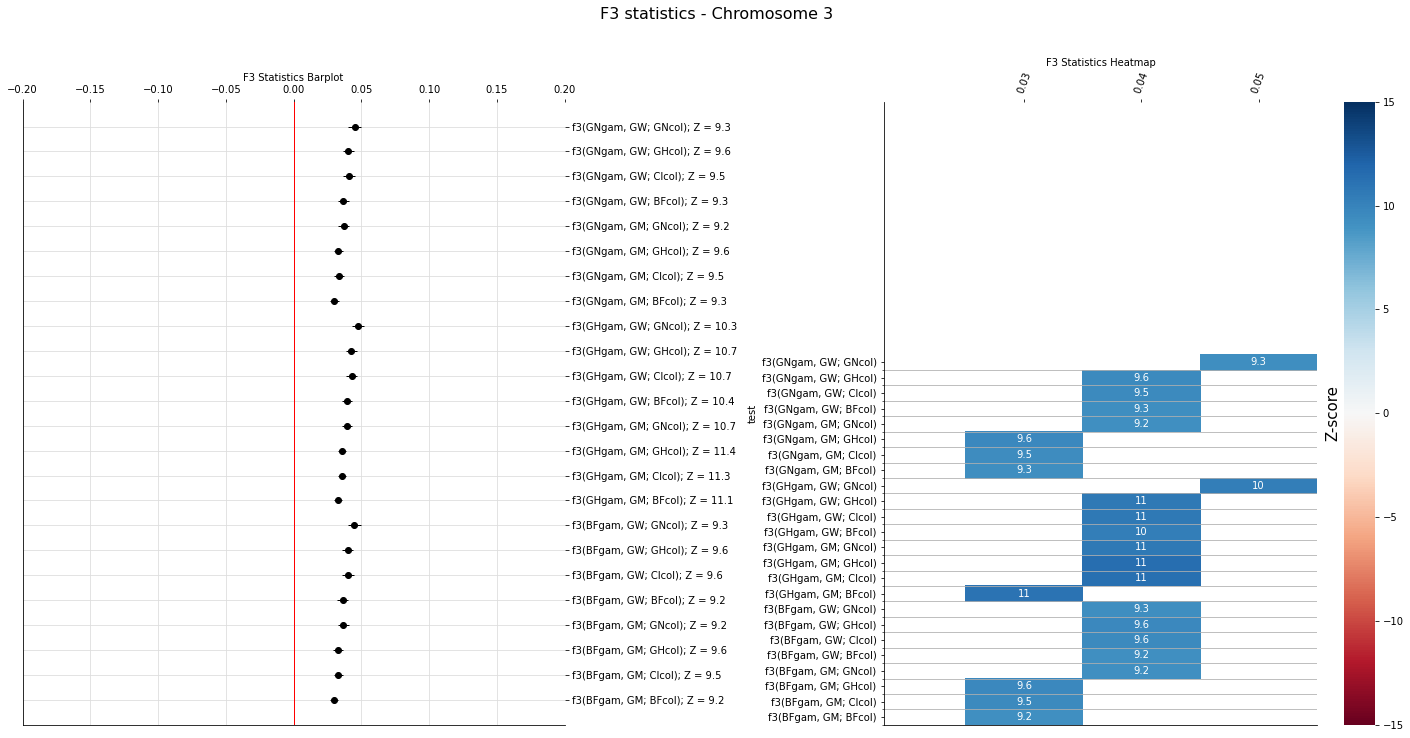

In [29]:
tbl_d_plot(f3_test_1, 'F3 statistics - Chromosome 3')

In [30]:
A = an_col
B = an_na
C = an_gam
f3_test_2 = f4_analys(A, B, C, chroms=("3L", "3R"),
                regions=(slice(18_000_000, 41_000_000), slice(1, 24000000)))

chromosome,test,f3,SE,Z
"3L,3R","f3(BFcol, GM; GHgam)",0.041,0.0066,6.2
"3L,3R","f3(BFcol, GM; BFgam)",0.042,0.0067,6.3
"3L,3R","f3(BFcol, GM; GNgam)",0.042,0.0067,6.3
"3L,3R","f3(BFcol, GW; GHgam)",0.034,0.0057,6.0
"3L,3R","f3(BFcol, GW; BFgam)",0.036,0.0059,6.0
"3L,3R","f3(BFcol, GW; GNgam)",0.036,0.0059,6.0
"3L,3R","f3(GNcol, GM; GHgam)",0.072,0.0054,13.3
"3L,3R","f3(GNcol, GM; BFgam)",0.073,0.0055,13.3
"3L,3R","f3(GNcol, GM; GNgam)",0.074,0.0055,13.3
"3L,3R","f3(GNcol, GW; GHgam)",0.063,0.0046,13.9


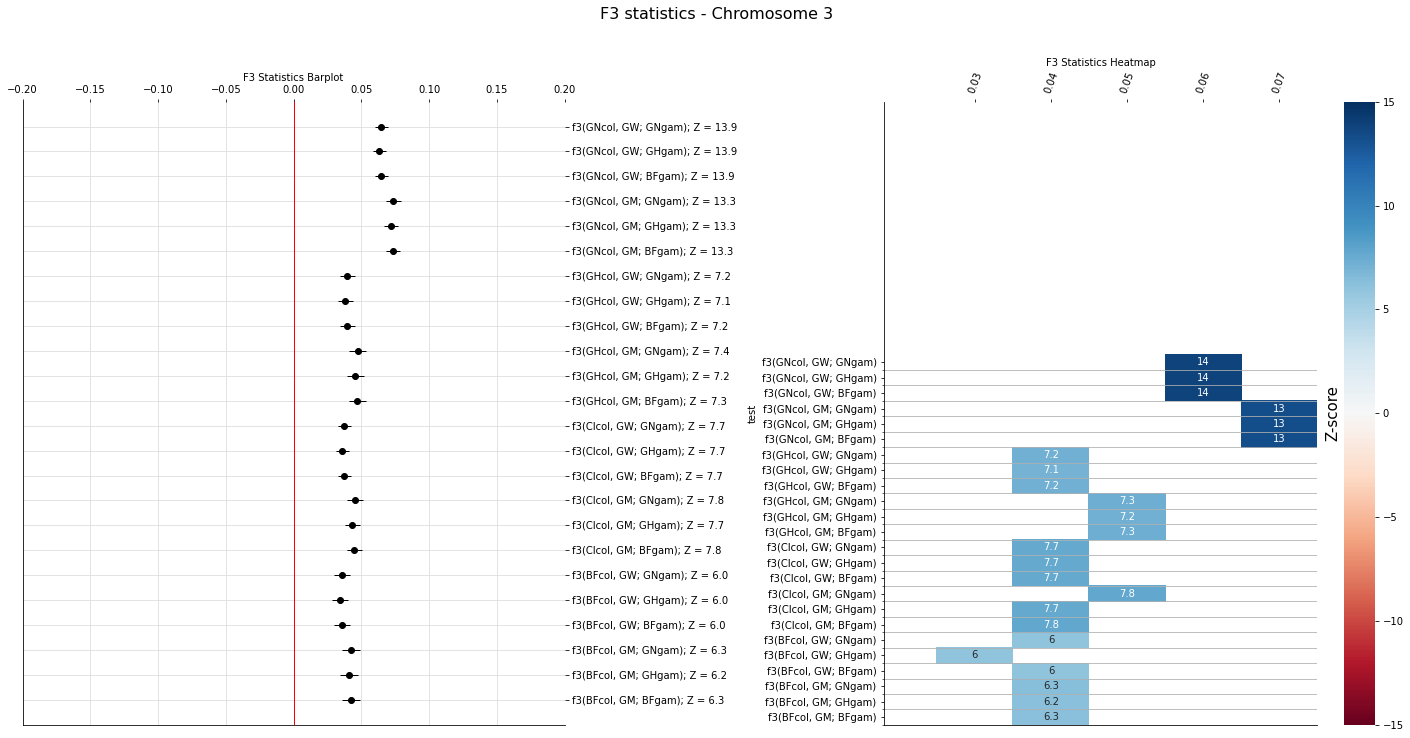

In [31]:
tbl_d_plot(f3_test_2, 'F3 statistics - Chromosome 3')

-------------------------------
## Fst

In [12]:
def f4_analysis(chroms, A, B, regions=None, blen=100000, plot=False, ax=None):
    
    
    
    region_str = ",".join(["{0}_{1}".format(r.start, r.stop) for r in regions])
    
    key = (",".join(chroms), region_str, A, B, blen)
    if key in fourpop_cache:
        # re-use from cache
        d, d_se, d_vb, d_vj = fourpop_cache[key]
        
    else:
        # load allele counts
        aca = dask.array.vstack([load_ac(chrom, A)[region] for chrom, region in zip(chroms, regions)])
        acb = dask.array.vstack([load_ac(chrom, B)[region] for chrom, region in zip(chroms, regions)])
            
        # run D test
        d, d_se, d_vb, d_vj = allel.average_hudson_fst(aca, acb, 
                                                                     blen=blen)
        
        # cache for re-use
        fourpop_cache[key] = d, d_se, d_vb, d_vj
    
    return d, d_se, d_vb, d_vj

def f4_analys(As, Bs, chroms=chromosomes, regions=None, blen=100000):
    
    if regions is None:
        regions = [slice(None)] * 4
    
    region_str = ",".join(["{0}_{1}".format(r.start, r.stop) for r in regions])
    # normalise inputs
    if not isinstance(chroms, (list, tuple)):
        chroms = [chroms]
    if not isinstance(As, (list, tuple)):
        As = [As]
    if not isinstance(Bs, (list, tuple)):
        Bs = [Bs]

    # setup output table
    tbl = [['chromosome', 'test', 'Fst', 'SE']]

    for A in As:
        for B in Bs:
            if A != B:
                            d, d_se, _, _ = f4_analysis(chroms, A, B,  
                                                             regions=regions, blen=blen)
                            test = 'Fst(%s, %s)' % (A, B)
                            row = [",".join(chroms), test, d, d_se]
                            tbl += [row]

    # display results
    (etl
     .wrap(tbl)
     .interpolate('Fst', '%.3f')
     .interpolate('SE', '%.4f')
     .displayall(index_header=False))
    return tbl

In [13]:
A = an_col
B = an_na

In [107]:
f4_analys(A, B, chroms=("3L", "3R"),
                regions=(slice(18_000_000, 41_000_000), slice(1, 24000000)))

chromosome,test,Fst,SE
"3L,3R","Fst(BFcol, GM)",0.057,0.0061
"3L,3R","Fst(BFcol, GW)",0.049,0.0061
"3L,3R","Fst(GNcol, GM)",0.076,0.0042
"3L,3R","Fst(GNcol, GW)",0.065,0.0040
"3L,3R","Fst(CIcol, GM)",0.056,0.0050
"3L,3R","Fst(CIcol, GW)",0.047,0.0048
"3L,3R","Fst(GHcol, GM)",0.058,0.0056
"3L,3R","Fst(GHcol, GW)",0.049,0.0055


In [16]:
A = an_gam
B = an_na

In [17]:
fst = f4_analys(A, B, chroms=("3L", "3R"),
                regions=(slice(18_000_000, 41_000_000), slice(1, 24000000)))

chromosome,test,Fst,SE
"3L,3R","Fst(GHgam, GM)",0.050,0.0037
"3L,3R","Fst(GHgam, GW)",0.053,0.0048
"3L,3R","Fst(CMgam, GM)",0.046,0.0038
"3L,3R","Fst(CMgam, GW)",0.050,0.0048
"3L,3R","Fst(BFgam, GM)",0.046,0.0038
"3L,3R","Fst(BFgam, GW)",0.050,0.0048
"3L,3R","Fst(GNgam, GM)",0.046,0.0039
"3L,3R","Fst(GNgam, GW)",0.050,0.0049


In [15]:
A = an_na
B = an_na
fst = f4_analys(A, B, chroms=("3L", "3R"),
                regions=(slice(18_000_000, 41_000_000), slice(1, 24000000)))

chromosome,test,Fst,SE
"3L,3R","Fst(GM, GW)",0.011,0.0008
"3L,3R","Fst(GW, GM)",0.011,0.0008


In [18]:
A = an_gam
B = an_col
fst = f4_analys(A, B, chroms=("3L", "3R"),
                regions=(slice(18_000_000, 41_000_000), slice(1, 24000000)))

chromosome,test,Fst,SE
"3L,3R","Fst(GHgam, BFcol)",0.069,0.0081
"3L,3R","Fst(GHgam, GNcol)",0.099,0.0068
"3L,3R","Fst(GHgam, CIcol)",0.073,0.0073
"3L,3R","Fst(GHgam, GHcol)",0.075,0.0078
"3L,3R","Fst(CMgam, BFcol)",0.068,0.0086
"3L,3R","Fst(CMgam, GNcol)",0.099,0.0072
"3L,3R","Fst(CMgam, CIcol)",0.073,0.0077
"3L,3R","Fst(CMgam, GHcol)",0.075,0.0083
"3L,3R","Fst(BFgam, BFcol)",0.067,0.0084
"3L,3R","Fst(BFgam, GNcol)",0.098,0.0071


In [19]:
A = an_gam
B = an_gam
fst = f4_analys(A, B, chroms=("3L", "3R"),
                regions=(slice(18_000_000, 41_000_000), slice(1, 24000000)))

chromosome,test,Fst,SE
"3L,3R","Fst(GHgam, CMgam)",0.010,0.0009
"3L,3R","Fst(GHgam, BFgam)",0.008,0.0007
"3L,3R","Fst(GHgam, GNgam)",0.009,0.0008
"3L,3R","Fst(CMgam, GHgam)",0.010,0.0009
"3L,3R","Fst(CMgam, BFgam)",0.002,0.0003
"3L,3R","Fst(CMgam, GNgam)",0.003,0.0006
"3L,3R","Fst(BFgam, GHgam)",0.008,0.0007
"3L,3R","Fst(BFgam, CMgam)",0.002,0.0003
"3L,3R","Fst(BFgam, GNgam)",0.001,0.0002
"3L,3R","Fst(GNgam, GHgam)",0.009,0.0008


In [20]:
A = an_col
B = an_col
fst = f4_analys(A, B, chroms=("3L", "3R"),
                regions=(slice(18_000_000, 41_000_000), slice(1, 24000000)))

chromosome,test,Fst,SE
"3L,3R","Fst(BFcol, GNcol)",0.048,0.0018
"3L,3R","Fst(BFcol, CIcol)",0.013,0.0009
"3L,3R","Fst(BFcol, GHcol)",0.014,0.0011
"3L,3R","Fst(GNcol, BFcol)",0.048,0.0018
"3L,3R","Fst(GNcol, CIcol)",0.041,0.0008
"3L,3R","Fst(GNcol, GHcol)",0.045,0.0011
"3L,3R","Fst(CIcol, BFcol)",0.013,0.0009
"3L,3R","Fst(CIcol, GNcol)",0.041,0.0008
"3L,3R","Fst(CIcol, GHcol)",0.008,0.0005
"3L,3R","Fst(GHcol, BFcol)",0.014,0.0011


In [ ]:
def plot_pairwise_fst(rname, chrom, start, stop, mask=True, blen=10000, ax=None):
    
    if ax is None:
        fig, ax = plt.subplots()
        sns.despine(ax=ax)
        
    fst, se = compute_pairwise_fst(chrom, start, stop, blen=blen)
    data = scipy.spatial.distance.squareform(fst).copy()
    data[data < 0] = 0
    if mask:
        mask = np.zeros_like(data)
        mask[np.triu_indices_from(mask)] = True
    else:
        mask = None
    
    xtl = list(fst_pops)
    xtl[-1] = ''
    ytl = list(fst_pops)
    ytl[0] = ''
    sns.heatmap(data, ax=ax, vmin=0, cmap='Greys', 
                xticklabels=xtl, yticklabels=ytl, 
                mask=mask, cbar=False, annot=True, fmt='.3f')
    
    ax.tick_params(length=0)
    if rname:
        ax.set_title(rname, fontweight='bold')
    ax.set_xlabel('$F_{ST}$')

----------------------------

In [13]:
A = an_col
B = an_na

In [14]:
f4_analys(A, B, chroms=("3L", "3R"),
                regions=(slice(18_000_000, 41_000_000), slice(1, 24000000)))

chromosome,test,Fst,SE
"3L,3R","Fst(BFcol, GM)",0.057,0.0061
"3L,3R","Fst(BFcol, GW)",0.049,0.0061
"3L,3R","Fst(GNcol, GM)",0.076,0.0042
"3L,3R","Fst(GNcol, GW)",0.065,0.0040
"3L,3R","Fst(CIcol, GM)",0.056,0.0050
"3L,3R","Fst(CIcol, GW)",0.047,0.0048
"3L,3R","Fst(GHcol, GM)",0.058,0.0056
"3L,3R","Fst(GHcol, GW)",0.049,0.0055


[['chromosome', 'test', 'Fst', 'SE'],
 ['3L,3R', 'Fst(BFcol, GM)', 0.05701667824256037, 0.006130277255662991],
 ['3L,3R', 'Fst(BFcol, GW)', 0.048933737938861244, 0.006122451284231227],
 ['3L,3R', 'Fst(GNcol, GM)', 0.07611515992247896, 0.004175290540087337],
 ['3L,3R', 'Fst(GNcol, GW)', 0.06518860582017302, 0.003950164766444066],
 ['3L,3R', 'Fst(CIcol, GM)', 0.05631382156678602, 0.005021736119445194],
 ['3L,3R', 'Fst(CIcol, GW)', 0.04684935793790072, 0.004848413869162432],
 ['3L,3R', 'Fst(GHcol, GM)', 0.058377588878375554, 0.005634695127214969],
 ['3L,3R', 'Fst(GHcol, GW)', 0.048877751912418936, 0.005471414516314411]]

In [15]:
A = an_gam
B = an_na

In [16]:
fst = f4_analys(A, B, chroms=("3L", "3R"),
                regions=(slice(18_000_000, 41_000_000), slice(1, 24000000)))

chromosome,test,Fst,SE
"3L,3R","Fst(GHgam, GM)",0.050,0.0037
"3L,3R","Fst(GHgam, GW)",0.053,0.0048
"3L,3R","Fst(BFgam, GM)",0.046,0.0038
"3L,3R","Fst(BFgam, GW)",0.050,0.0048
"3L,3R","Fst(GNgam, GM)",0.046,0.0039
"3L,3R","Fst(GNgam, GW)",0.050,0.0049


In [17]:
A = an_na
B = an_na
fst = f4_analys(A, B, chroms=("3L", "3R"),
                regions=(slice(18_000_000, 41_000_000), slice(1, 24000000)))

chromosome,test,Fst,SE
"3L,3R","Fst(GM, GW)",0.011,0.0008
"3L,3R","Fst(GW, GM)",0.011,0.0008


In [18]:
A = an_gam
B = an_col
fst = f4_analys(A, B, chroms=("3L", "3R"),
                regions=(slice(18_000_000, 41_000_000), slice(1, 24000000)))

chromosome,test,Fst,SE
"3L,3R","Fst(GHgam, BFcol)",0.069,0.0081
"3L,3R","Fst(GHgam, GNcol)",0.099,0.0068
"3L,3R","Fst(GHgam, CIcol)",0.073,0.0073
"3L,3R","Fst(GHgam, GHcol)",0.075,0.0078
"3L,3R","Fst(BFgam, BFcol)",0.067,0.0084
"3L,3R","Fst(BFgam, GNcol)",0.098,0.0071
"3L,3R","Fst(BFgam, CIcol)",0.072,0.0076
"3L,3R","Fst(BFgam, GHcol)",0.074,0.0081
"3L,3R","Fst(GNgam, BFcol)",0.067,0.0085
"3L,3R","Fst(GNgam, GNcol)",0.098,0.0071


In [19]:
A = an_gam
B = an_gam
fst = f4_analys(A, B, chroms=("3L", "3R"),
                regions=(slice(18_000_000, 41_000_000), slice(1, 24000000)))

chromosome,test,Fst,SE
"3L,3R","Fst(GHgam, BFgam)",0.008,0.0007
"3L,3R","Fst(GHgam, GNgam)",0.009,0.0008
"3L,3R","Fst(BFgam, GHgam)",0.008,0.0007
"3L,3R","Fst(BFgam, GNgam)",0.001,0.0002
"3L,3R","Fst(GNgam, GHgam)",0.009,0.0008
"3L,3R","Fst(GNgam, BFgam)",0.001,0.0002


In [20]:
A = an_col
B = an_col
fst = f4_analys(A, B, chroms=("3L", "3R"),
                regions=(slice(18_000_000, 41_000_000), slice(1, 24000000)))

chromosome,test,Fst,SE
"3L,3R","Fst(BFcol, GNcol)",0.048,0.0018
"3L,3R","Fst(BFcol, CIcol)",0.013,0.0009
"3L,3R","Fst(BFcol, GHcol)",0.014,0.0011
"3L,3R","Fst(GNcol, BFcol)",0.048,0.0018
"3L,3R","Fst(GNcol, CIcol)",0.041,0.0008
"3L,3R","Fst(GNcol, GHcol)",0.045,0.0011
"3L,3R","Fst(CIcol, BFcol)",0.013,0.0009
"3L,3R","Fst(CIcol, GNcol)",0.041,0.0008
"3L,3R","Fst(CIcol, GHcol)",0.008,0.0005
"3L,3R","Fst(GHcol, BFcol)",0.014,0.0011


In [21]:
def plot_pairwise_fst(rname, chrom, start, stop, mask=True, blen=10000, ax=None):
    
    if ax is None:
        fig, ax = plt.subplots()
        sns.despine(ax=ax)
        
    fst, se = compute_pairwise_fst(chrom, start, stop, blen=blen)
    data = scipy.spatial.distance.squareform(fst).copy()
    data[data < 0] = 0
    if mask:
        mask = np.zeros_like(data)
        mask[np.triu_indices_from(mask)] = True
    else:
        mask = None
    
    xtl = list(fst_pops)
    xtl[-1] = ''
    ytl = list(fst_pops)
    ytl[0] = ''
    sns.heatmap(data, ax=ax, vmin=0, cmap='Greys', 
                xticklabels=xtl, yticklabels=ytl, 
                mask=mask, cbar=False, annot=True, fmt='.3f')
    
    ax.tick_params(length=0)
    if rname:
        ax.set_title(rname, fontweight='bold')
    ax.set_xlabel('$F_{ST}$')